In [ ]:
# default_exp subcoco_effdet_icevision_fastai

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Exploring Object Detection using Icevision w/ FastAI

I was unable to make much progress using Pytorch Lightning & Torch Vision on a tiny subset of Coco Dataset. 
I got a model to run for hundreds of epochs, with seemingly improving training loss, but prediction is still garbage.

So I decided to get an end to end object detection working example before diving back in. This time I chose https://github.com/airctic/icevision

Following their [first example](https://airctic.com/examples/training/) for FastAI...

In [ ]:
#export
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import PIL
import re
import requests
import tarfile
import sys
import torch
import torch.multiprocessing
import torchvision
import xml.etree.ElementTree

from collections import defaultdict
from IPython.utils import io
from pathlib import Path
from PIL import Image, ImageStat
from shutil import copyfile, rmtree
from tqdm import tqdm
from typing import Hashable, List, Tuple, Union

Need some magic to make notebook work in Colab

In [ ]:
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    os.chdir('/content/drive/My Drive/ColabData')
    print(f'Current Directory is now {os.getcwd()}')
    !wget -O 'mcbbox/subcoco_utils.py' https://raw.githubusercontent.com/bguan/mcbbox/master/mcbbox/subcoco_utils.py
    !pip install torch torchvision albumentation==0.5.0 fastai icevision==0.3.0 effdet==0.2.1 gpumonitor

In [ ]:
#export
import fastai
import icevision
import icevision.backbones as backbones
import icevision.models
import icevision.models.efficientdet as efficientdet
import icevision.models.rcnn.faster_rcnn as faster_rcnn
import icevision.tfms as tfms

from albumentations import ShiftScaleRotate
from fastai.test_utils import synth_learner
from fastai.learner import Learner
from fastai.callback.training import GradientAccumulation
from fastai.callback.tracker import Callback, EarlyStoppingCallback, SaveModelCallback
from gpumonitor.monitor import GPUStatMonitor
from gpumonitor.callbacks.lightning import PyTorchGpuMonitorCallback
from icevision.core import BBox, ClassMap, BaseRecord
from icevision.parsers import Parser
from icevision.parsers.mixins import LabelsMixin, BBoxesMixin, FilepathMixin, SizeMixin
from icevision.data import Dataset
from icevision.metrics.coco_metric import COCOMetricType, COCOMetric
from icevision.utils import denormalize_imagenet
from icevision.visualize.show_data import *

from mcbbox.subcoco_utils import *

if torch.cuda.is_available(): 
    monitor = GPUStatMonitor(delay=1)

print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, fastai {fastai.__version__}, icevision {icevision.__version__}")

if is_notebook():
    from nbdev.showdoc import *

Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.7.0, torchvision 0.8.1, fastai 2.1.2, icevision 0.3.0


# Setup the Run

Centralize all the training run parameters

In [ ]:
#hide
test = True
if test:
    img_sz, bs, acc, workers, head_runs, full_runs = 128, 4, 8, 4, 1, 1
    datadir, url, img_subdir = '/tmp', 'http://files.fast.ai/data/examples/coco_tiny.tgz', 'train'
else:
    img_sz, bs, acc, workers, head_runs, full_runs = 512, 3, 12, 4, 5, 20
    datadir, url, img_subdir = 'workspace', 'https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz', 'train_sample'
    
stem = Path(url).stem
img_dir=f'{datadir}/{stem}/{img_subdir}'

## Download a Sample of COCO Data

The full COCO Dataset is huge (~50GB?). For my self education exploring object detection, with the intention of using pretrained model in transfer learning, it is not practical to deal with dataset this big as my first project.  Luckily, the kind folks at [FastAI](https://fast.ai) have prepared some convenient subsets, the medium size 3GB https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz seems like a good candidate.  The 800KB "http://files.fast.ai/data/examples/coco_tiny.tgz" on the other hand seems way too small, thus may not have enough data for adequate training.

In [ ]:
train_json = fetch_subcoco(datadir=datadir, url=url, img_subdir=img_subdir)

## Check Annotations

Let's load and inspect the annotation file that comes with the coco tiny dataset...

In [ ]:
train_json['categories'], train_json['images'][0], [a for a in train_json['annotations'] if a['image_id']==train_json['images'][0]['id'] ]

([{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 {'id': 542959, 'file_name': '000000542959.jpg'},
 [{'image_id': 542959, 'bbox': [32.52, 86.34, 8.53, 9.41], 'category_id': 62},
  {'image_id': 542959, 'bbox': [98.12, 110.52, 1.95, 4.07], 'category_id': 86},
  {'image_id': 542959, 'bbox': [91.28, 51.62, 3.95, 5.72], 'category_id': 86},
  {'image_id': 542959,
   'bbox': [110.48, 110.82, 14.55, 15.22],
   'category_id': 62},
  {'image_id': 542959,
   'bbox': [96.63, 50.18, 18.67, 13.46],
   'category_id': 62},
  {'image_id': 542959,
   'bbox': [0.69, 111.73, 11.8, 13.06],
   'category_id': 62}])

## Digest the Dataset for useful Stats

Do some basic analysis of the data to get numbers like total images, boxes, and average box count per image...

In [ ]:
stats = load_stats(train_json, img_dir=img_dir, force_reload=False)
print(
    f"Categories {stats.num_cats}, Images {stats.num_imgs}, Boxes {stats.num_bboxs}, avg (w,h) {(stats.avg_width, stats.avg_height)}"
    f"avg cats/img {stats.avg_ncats_per_img:.1f}, avg boxs/img {stats.avg_nboxs_per_img:.1f}, avg boxs/cat {stats.avg_nboxs_per_cat:.1f}.")

print(f"Image means by channel {stats.chn_means}, std.dev by channel {stats.chn_stds}")
stats.num_imgs, stats.lbl2name, stats.lbl2cat, stats.cat2lbl, stats.lbl2name

Categories 6, Images 200, Boxes 688, avg (w,h) (128.0, 128.0)avg cats/img 7.0, avg boxs/img 3.4, avg boxs/cat 114.7.
Image means by channel [126.2909314  109.02263367 100.61073242], std.dev by channel [65.60744282 65.09696176 60.4631069 ]


(200,
 {1: 'chair', 2: 'couch', 3: 'tv', 4: 'remote', 5: 'book', 6: 'vase'},
 {1: 62, 2: 63, 3: 72, 4: 75, 5: 84, 6: 86, 0: 0},
 {62: 1, 63: 2, 72: 3, 75: 4, 84: 5, 86: 6, 0: 0},
 {1: 'chair', 2: 'couch', 3: 'tv', 4: 'remote', 5: 'book', 6: 'vase'})

## Custom Parser for Icevision

In [ ]:
#export
class SubCocoParser(Parser, LabelsMixin, BBoxesMixin, FilepathMixin, SizeMixin):
    def __init__(self, stats:CocoDatasetStats, min_margin_ratio = 0, min_width_height_ratio = 0, quiet = True):
        self.stats = stats
        self.data = [] # list of tuple of form (img_id, wth, ht, bbox, label_id, img_path)
        skipped = 0
        for img_id, imgfname in stats.img2fname.items():
            imgf = stats.img_dir/imgfname
            if not os.path.isfile(imgf):
                skipped += 1
                continue
            width, height = stats.img2sz[img_id]
            bboxs = []
            lids = []
            for lid, x, y, w, h in stats.img2lbs[img_id]:
                if lid != None and box_within_bounds(x, y, w, h, width, height, min_margin_ratio, min_width_height_ratio):
                    b = [int(x), int(y), int(w), int(h)]
                    l = int(lid)
                    bboxs.append(b)
                    lids.append(l)
                else:
                    if not quiet: print(f"warning: skipping lxywh of {lid, x, y, w, h}")

            if len(bboxs) > 0:
                self.data.append( (img_id, width, height, bboxs, lids, imgf, ) )
            else:
                skipped += 1

        print(f"Skipped {skipped} out of {stats.num_imgs} images")

    def __iter__(self):
        yield from iter(self.data)

    def __len__(self):
        return len(self.data)

    def imageid(self, o) -> Hashable:
        return o[0]

    def filepath(self, o) -> Union[str, Path]:
        return o[5]

    def height(self, o) -> int:
        return o[2]

    def width(self, o) -> int:
        return o[1]

    def labels(self, o) -> List[int]:
        return o[4]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xywh(x,y,w,h) for x,y,w,h in o[3]]

    def image_width_height(self, o) -> Tuple[int, int]:
        img_id = o[0]
        return self.stats.img2sz[img_id]

## Load Data Using Custom Parser

To prevent bounding boxes being too close to margin or too small, especially after augmentation which performs transformations. 
I would set min_margin_ratio = 0.05, min_width_height_ratio = 0.05.  

However, IceVision 2.0 now has autofix which should address these issues, it does take a long time to run though...

In [ ]:
#export
def parse_subcoco(stats:CocoDatasetStats)->List[List[BaseRecord]]:
    parser = SubCocoParser(stats, min_width_height_ratio = 0.05) # no need min_margin_ratio = 0.05 as icevision autofix
    train_records, valid_records = parser.parse(autofix=False)
    return train_records, valid_records

In [ ]:
train_records, valid_records = parse_subcoco(stats)

Skipped 11 out of 200 images


## shows images with corresponding labels and boxes

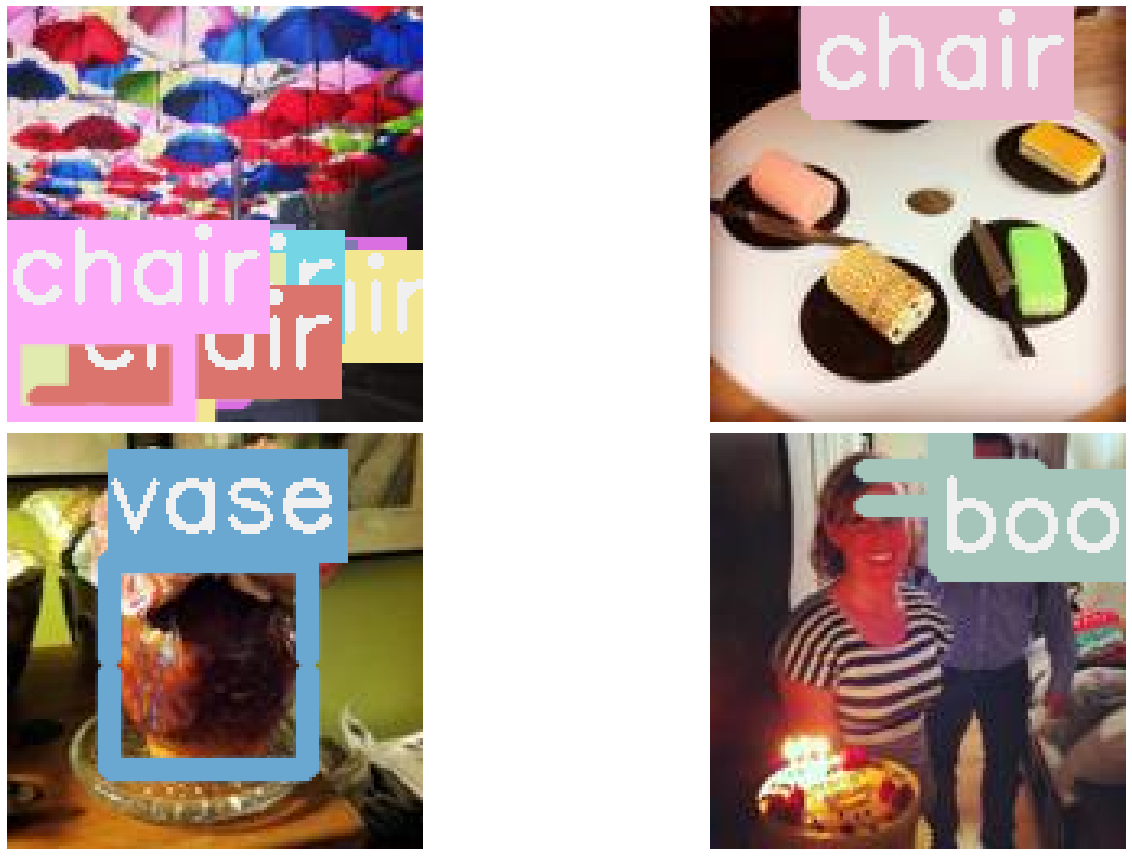

In [ ]:
class_map = ClassMap(list(stats.lbl2name.values()))
show_records(train_records[:4], ncols=2, class_map=class_map, show=True)

## Custom FastAI Callback to Include Metric in Save Model Filename

In [ ]:
#export
class SaveModelDupBestCallback(SaveModelCallback):
    "Extend SaveModelCallback to save a duplicate with metric added to end of filename"
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, with_opt=False, reset_on_fit=True):
        super().__init__(
            monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit,
            fname=fname, every_epoch=every_epoch, with_opt=with_opt, 
        )

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        super().after_epoch()
        if self.new_best or self.epoch==0:
            last_saved = self.last_saved_path
            saved_stem = last_saved.stem
            backup_stem = f'{saved_stem}@{self.epoch:03d}_{self.monitor}={self.best:.3f}'
            backup_file = backup_stem+(last_saved.suffix)
            backup_path = last_saved.parent / backup_file
            print(f'Backup {last_saved} as {backup_path}')
            if last_saved != backup_path: copyfile(last_saved, backup_path)

How can I unit test this? Copy idea from [FastAI Callback](https://github.com/fastai/fastai/blob/master/nbs/17_callback.tracker.ipynb)

In [ ]:
#hide
pid = os.getpid()
testpath = Path(f'/tmp/test-{pid}')
learn = synth_learner(n_trn=2, path=testpath)
bestcb = SaveModelDupBestCallback()
learn.fit(n_epoch=1, cbs=bestcb)  # First epoch should trigger best 
assert (testpath/'models/model.pth').exists()
best = bestcb.best
bestpath = f'models/model@000_valid_loss={best:.3f}.pth'
assert (testpath/bestpath).exists(), f'Expect {bestpath} to exist!'
rmtree(testpath)

epoch,train_loss,valid_loss,time
0,10.242552,6.722001,00:00


Better model found at epoch 0 with valid_loss value: 6.722001075744629.
Backup /tmp/test-229890/models/model.pth as /tmp/test-229890/models/model@000_valid_loss=6.722.pth


## Create Transforms, Model, Training and Validation Dataloaders, Learners

* Define transforms - using Albumentations transforms out of the box. 
* Use them to construct Datasets and Dataloaders. 
* Make a Learner

In [ ]:
#export
class FastGPUMonitorCallback(Callback):
    def __init__(self, delay=1, display_options=None):
        super(FastGPUMonitorCallback, self).__init__()
        self.delay = delay
        self.display_options = display_options if display_options else {}
        
    def before_epoch(self):
        self.monitor = GPUStatMonitor(self.delay, self.display_options)

    def after_epoch(self):
        self.monitor.stop()
        print("")
        self.monitor.display_average_stats_per_gpu()
        
def gen_transforms_and_learner(stats:CocoDatasetStats, 
                               train_records:List[BaseRecord], 
                               valid_records:List[BaseRecord], 
                               img_sz=128, 
                               bs=4, 
                               acc_cycs=8, 
                               num_workers=2):
    train_tfms = tfms.A.Adapter([
        *tfms.A.aug_tfms(
            size=img_sz,
            presize=img_sz+128,
            shift_scale_rotate = tfms.A.ShiftScaleRotate(shift_limit=.025, scale_limit=0.025, rotate_limit=9)
        ),
        tfms.A.Normalize(mean=stats.chn_means/255, std=stats.chn_stds/255)
    ]) 
    valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_sz), tfms.A.Normalize()])
    train_ds = Dataset(train_records, train_tfms)
    valid_ds = Dataset(valid_records, valid_tfms)
    # Using gradient accumulation to process minibatch of 32 images in 8 loops, i.e. 8 images per loop.
    # I ran this model w img 512x512x3 on my Dell XPS15 w GTX-1050 with 4GB VRAM, 16GM RAM, ~20min/epoch.
    backbone_name = "tf_efficientdet_lite0"
    model = efficientdet.model(model_name=backbone_name, img_size=img_sz, num_classes=len(stats.lbl2name))
    train_dl = efficientdet.train_dl(train_ds, batch_size=bs, num_workers=num_workers, shuffle=True)
    valid_dl = efficientdet.valid_dl(valid_ds, batch_size=bs, num_workers=max(1,num_workers//2), shuffle=False)

    monitor_metric = 'COCOMetric'
    metrics = [ COCOMetric(metric_type=COCOMetricType.bbox)]

    save_model_fname=f'{backbone_name}-{img_sz}'
    callbacks=[
        GradientAccumulation(bs*acc_cycs),
        SaveModelDupBestCallback(fname=save_model_fname, monitor=monitor_metric),
        EarlyStoppingCallback(monitor=monitor_metric, min_delta=0.001, patience=10),
        FastGPUMonitorCallback(delay=1)
    ]

    learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, cbs=callbacks)
    learn.freeze()

    return valid_tfms, learn, backbone_name

In [ ]:
inf_tfms, learn, backbone_name = gen_transforms_and_learner(stats, train_records, valid_records, 
                                                            img_sz=img_sz, bs=bs, acc_cycs=acc, num_workers=workers)

I have experimented with other models available out of box in IceVision, but ***efficientdet*** works the best. You can replace backbone_name, backbone, model, with the following values to test.

***backbone_name***
* "resnet_fpn.resnet18"

***backbone***
* backbones.resnet_fpn.resnet18(pretrained=True)
* backbones.resnet_fpn.resnet34(pretrained=True)
* backbones.resnet_fpn.resnet50(pretrained=True) # Default
* backbones.resnet_fpn.resnet101(pretrained=True)
* backbones.resnet_fpn.resnet152(pretrained=True)
* backbones.resnet_fpn.resnext50_32x4d(pretrained=True)
* backbones.resnet_fpn.resnext101_32x8d(pretrained=True)
* backbones.resnet_fpn.wide_resnet50_2(pretrained=True)
* backbones.resnet_fpn.wide_resnet101_2(pretrained=True)

***model***
* faster_rcnn.model(backbone=backbone, num_classes=len(stats.lbl2name))


## Train using FastAI


[0] GeForce GTX 1050 | 44'C,  17 % |  1825 /  4042 MB | brian(589M) root(797M) brian(169M) brian(168M)

[0] GeForce GTX 1050 | 46'C,  11 % |  1844 /  4042 MB | brian(709M) root(797M) brian(169M) brian(168M)

[0] GeForce GTX 1050 | 48'C,  18 % |  1842 /  4042 MB | brian(713M) root(797M) brian(169M) brian(160M)


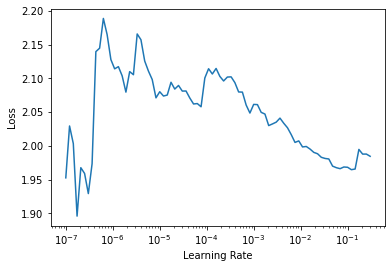

In [ ]:
# # Only do this if GPU avail, otherwise Github CI times out
if torch.cuda.is_available():
    learn.lr_find()

In [ ]:
#export
# Wrap in function this doesn't run upon import or when generating docs
def run_training(learn:Learner, min_lr=0.01, head_runs=1, full_runs=1):
    monitor.display_average_stats_per_gpu()
    print(f"Training for {head_runs}+{full_runs} epochs at min LR {min_lr}")
    learn.fine_tune(full_runs, min_lr, freeze_epochs=head_runs)

In [ ]:
# Only do this if GPU avail, otherwise Github CI times out
if torch.cuda.is_available():
    run_training(learn, min_lr=0.01, head_runs=head_runs, full_runs=full_runs)

[0] GeForce GTX 1050 | 41'C,   0 % |  1498 /  4042 MB | root(789M) brian(169M) brian(158M)
Training for 1+1 epochs at min LR 0.01


epoch,train_loss,valid_loss,COCOMetric,time
0,1.981430,1.779449,0.000462,00:18


Better model found at epoch 0 with COCOMetric value: 0.00046220782177706644.
Backup models/tf_efficientdet_lite0-128.pth as models/tf_efficientdet_lite0-128@000_COCOMetric=0.000.pth

[0] GeForce GTX 1050 | 41'C,  16 % |  1862 /  4042 MB | brian(713M) root(797M) brian(169M) brian(156M)


epoch,train_loss,valid_loss,COCOMetric,time
0,1.715183,1.810189,0.000578,00:18


Better model found at epoch 0 with COCOMetric value: 0.0005782586507956835.
Backup models/tf_efficientdet_lite0-128.pth as models/tf_efficientdet_lite0-128@000_COCOMetric=0.001.pth

[0] GeForce GTX 1050 | 45'C,  13 % |  1901 /  4042 MB | brian(657M) root(798M) brian(169M) brian(191M)


## Inference

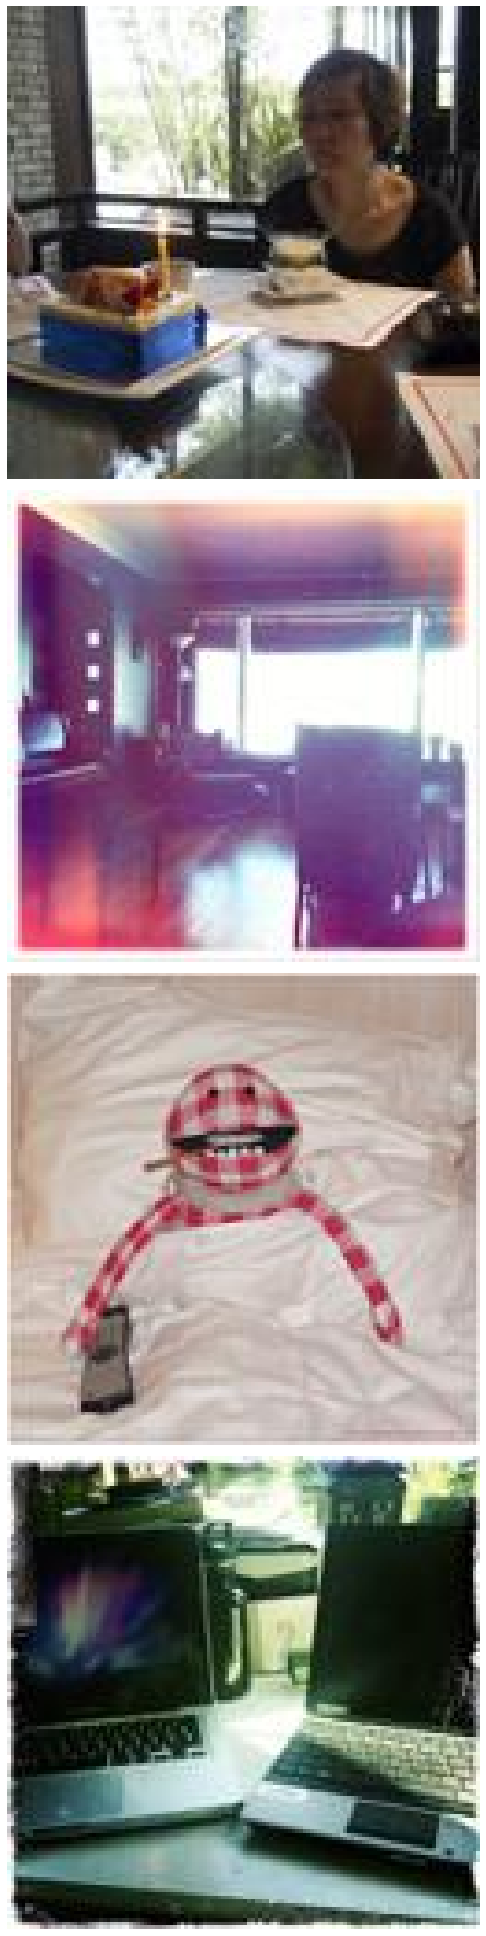

In [ ]:
# Only do this if GPU avail, otherwise Github CI times out
if torch.cuda.is_available():
    infer_ds = Dataset(valid_records[:4], inf_tfms)
    infer_dl = efficientdet.infer_dl(infer_ds, batch_size=4, shuffle=True)
    samples, preds = efficientdet.predict_dl(learn.model, infer_dl)
    imgs = [sample["img"] for sample in samples]
    show_preds(
        samples=imgs[:4],
        preds=preds[:4],
        class_map=class_map,
        denormalize_fn=denormalize_imagenet,
        ncols=1,
        figsize=(36,27)
    )

As you can see, training after only 2 epochs does not produce a usable model.

## Saving Final Model Explicitly

Saving it explicitly after all the epochs.

In [ ]:
#export
def save_final(learn:Learner, save_model_fpath:str):
    torch.save(learn.model.state_dict(), save_model_fpath)

In [ ]:
final_saved_model_fpath = f"models/{backbone_name}-subcoco-{img_sz}-runs-{head_runs}+{full_runs}-final.pth"
save_final(learn, final_saved_model_fpath)

## Inference w/ Pretrained Model

Load a pretrained model.

In [ ]:
pretrained_model = efficientdet.model(model_name=backbone_name, num_classes=len(stats.lbl2name), img_size=img_sz)
pretrained_model.load_state_dict(torch.load(final_saved_model_fpath))

<All keys matched successfully>

Run Inference with first 4 of the validation image...

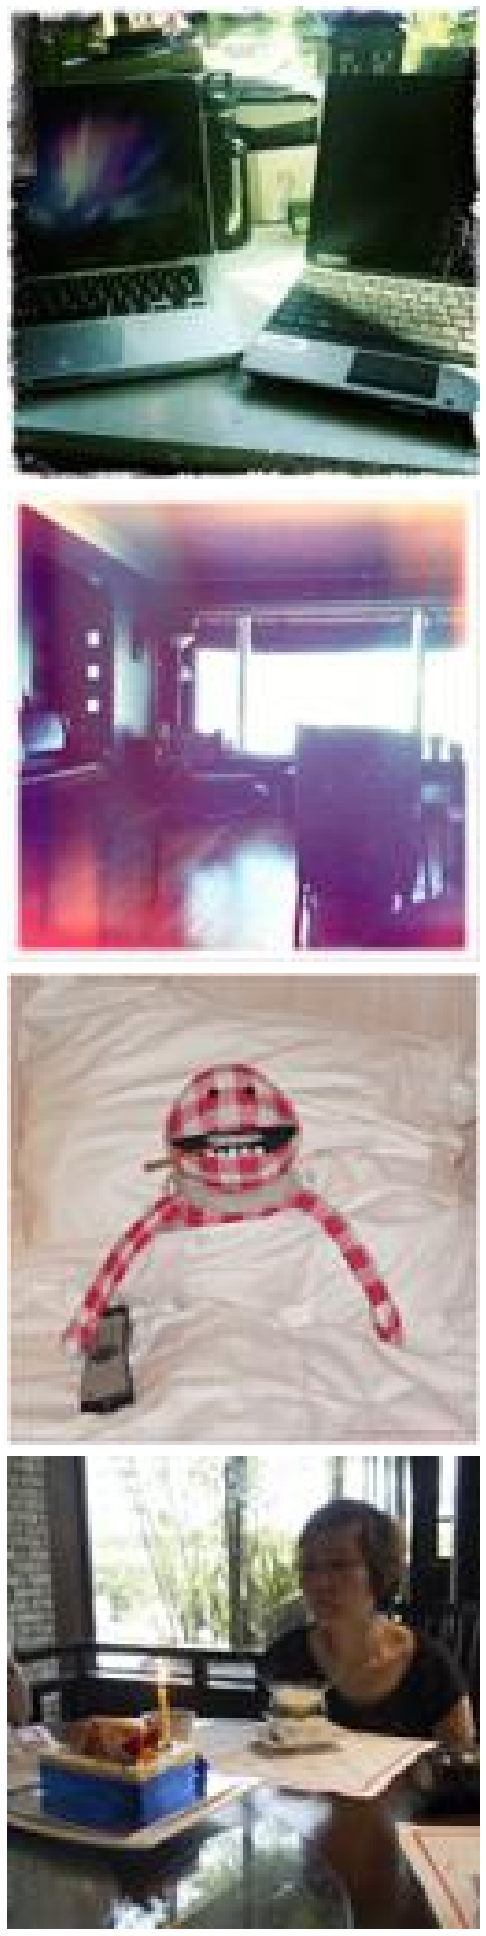

In [ ]:
if torch.cuda.is_available():
    infer_ds = Dataset(valid_records[:4], inf_tfms)
    infer_dl = efficientdet.infer_dl(infer_ds, batch_size=4, shuffle=False)
    samples, preds = efficientdet.predict_dl(pretrained_model.cuda(), infer_dl)
    imgs = [sample["img"] for sample in samples]
    show_preds(
        samples=imgs[:4],
        preds=preds[:4],
        class_map=class_map,
        denormalize_fn=denormalize_imagenet,
        ncols=1,
        figsize=(36,27)
    )